### Optical pulse broadening

This is a test to confirm c is recognized as light speed.[m/s]
299792458.0

timestep [s]
1.00000E-15



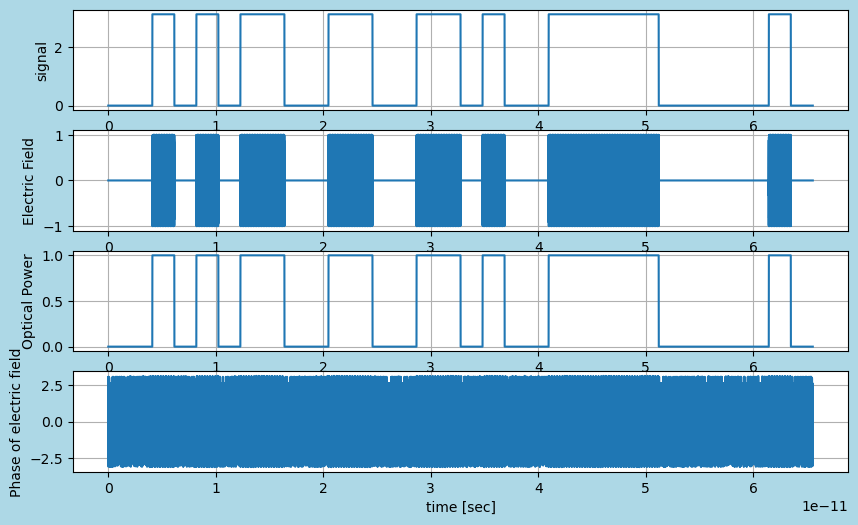

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftshift
from scipy.constants import c
from scipy.signal import butter, lfilter, freqz

import mach_zender_interferometer_time_def
from prbs_def import prbs_1, prbs_2

samplerate = 2 **16 # Number of Points
timestep = 1e-15 #[s]

print("This is a test to confirm c is recognized as light speed.[m/s]")
print(c)
print('')

print("timestep [s]")
print(f'{timestep:.5E}')
print('')

tcol = np.linspace(0.0, timestep * samplerate, samplerate, endpoint=False)

wl1 = 1550e-9 
lightfreq1 = c / wl1

numberofpointspersymbol = 32

signalcol =prbs_2(samplerate, numberofpointspersymbol) + 0.5*np.pi

opl1 = 2*np.pi * lightfreq1 * tcol # phase of local oscillator [rad]
opl2 = 2*np.pi * lightfreq1 * tcol + signalcol # Phase of Modulated Light [rad]    

#Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
Ein1 = np.array([[0.707+0.707j],[0-0j]])

oplcommon1=100 #Common Path Length 1
oplcommon2=100 #Common Path Length 2

PT1 = 0.5 # PT: Power Transmission of first beam splitter
PT2 = 0.5 # PT: Power Transmission of second beam splitter

Port1_1_EFcol = np.zeros(samplerate, dtype=complex)
Port1_2_EFcol = np.zeros(samplerate, dtype=complex)

P1_powercol = np.zeros(samplerate)
P1_phasecol = np.zeros(samplerate)

P2_powercol = np.zeros(samplerate)
P2_phasecol = np.zeros(samplerate)

for ii in range(samplerate):
    
    t = tcol[ii]
    phase1 = opl1[ii]
    phase2 = opl2[ii]
    
    Eout1 = mach_zender_interferometer_time_def.propagate1(oplcommon1, oplcommon2, Ein1)
    Ein2 = Eout1
    
    Eout2 = mach_zender_interferometer_time_def.beamsplitter(PT1, Ein2)
    # Enter first beam splitter (or Fiber Coupler)
    Ein3 = Eout2
    
    Eout3 = mach_zender_interferometer_time_def.propagate1(phase1, phase2, Ein3)
    # Each path experience different path length
    Ein4 = Eout3
    
    Eout4 = mach_zender_interferometer_time_def.beamsplitter(PT2, Ein4)
    # Enter second beam splitter (or Fiber Coupler)
    Ein5 = Eout4
    
    Eout5 = mach_zender_interferometer_time_def.propagate1(oplcommon1, oplcommon2, Ein5)
    Ein6 = Eout5
    
    Eout_port1 = Ein6[0,0]
    Port1_1_EFcol[ii] = Eout_port1

    # Optical power is calculated as square of absolute electric field strength
    power_11 = (np.abs(Eout_port1))**2 
    P1_powercol[ii] = power_11
    
    P1_phase = np.angle(Eout_port1)
    P1_phasecol[ii] = P1_phase
    
    #Eout_port_2 = Ein6[1,0]
    
    #power_22 = (np.abs(Eout_port_2))**2
    #P2_powercol[ii] = power_22
    
    #P2_phase = np.angle(Eout_port_2)
    #P2_phasecol[ii] = P2_phase


fig = plt.figure(figsize = (10,6), facecolor='lightblue')

ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(tcol,signalcol)
ax1.set_ylabel("signal")
ax1.grid()

#2 Electric Field
ax2.plot(tcol,np.real(Port1_1_EFcol),'-')
ax2.set_ylabel("Electric Field")
ax2.grid()

# Power
ax3.plot(tcol,P1_powercol)
ax3.set_ylabel("Optical Power")
ax3.grid()
    
ax4.plot(tcol,P1_phasecol)
ax4.set_xlabel("time [sec]")
ax4.set_ylabel("Phase of electric field")
ax4.grid()

plt.show()

frequencystep:  7629394531.249999
Shape of Shifted_fft_random_analog_signal (Frequency Domain)
(131072,)

Shape of Shifted_f (Frequency Domain)
(131072,)



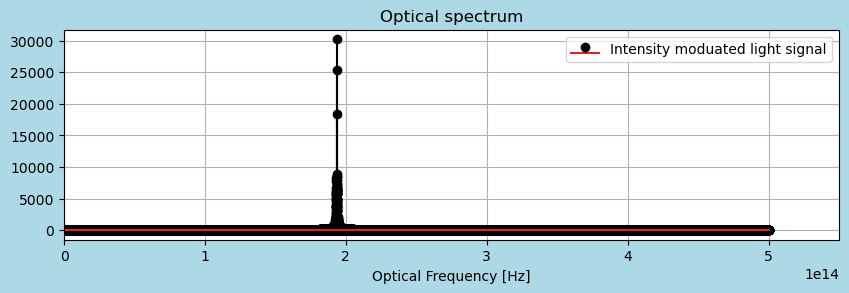

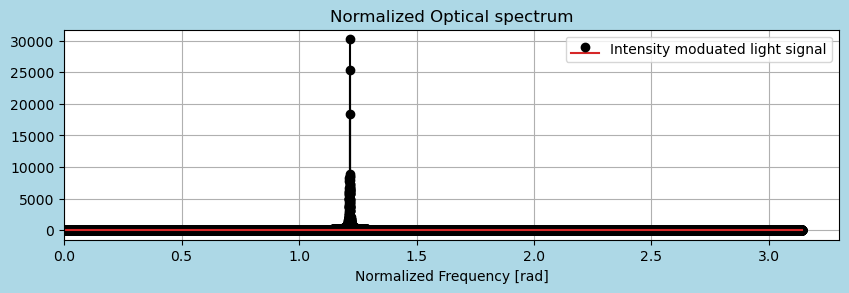

In [2]:

N = 2* samplerate

frequencystep = (1/timestep) * (1/N)
print("frequencystep: ", frequencystep)

Shifted_sampleIndex = np.arange(-N//2, N//2)
Shifted_f = Shifted_sampleIndex*frequencystep

fft_random_analog_signal = fft(Port1_1_EFcol, N)
Shifted_fft_random_analog_signal = fftshift(fft_random_analog_signal)

print('Shape of Shifted_fft_random_analog_signal (Frequency Domain)')
print(Shifted_fft_random_analog_signal.shape)
print('')

print('Shape of Shifted_f (Frequency Domain)')
print(Shifted_f.shape)
print('')

fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax1_1 = fig1.add_subplot(2, 1, 1)
ax1_1.set_title("Optical spectrum")
ax1_1.stem(Shifted_f, np.abs(Shifted_fft_random_analog_signal),"k",label='Intensity moduated light signal')
ax1_1.set_xlabel("Optical Frequency [Hz]")
ax1_1.set_xlim(0, frequencystep * samplerate * 1.1/1)
ax1_1.legend()
ax1_1.grid()


norm_freqcol = np.linspace(-1*np.pi, 1*np.pi, 2*samplerate, endpoint=False)

fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax2_1 = fig2.add_subplot(2, 1, 1)
ax2_1.stem(norm_freqcol, np.abs(Shifted_fft_random_analog_signal),"k",label='Intensity moduated light signal')
ax2_1.set_title("Normalized Optical spectrum")
ax2_1.set_xlabel("Normalized Frequency [rad]")
ax2_1.legend()
ax2_1.set_xlim(0, 1.05*np.pi)
ax2_1.grid()



### Filter Design

b =  [ 1.37167716e-06  0.00000000e+00 -5.48670863e-06  0.00000000e+00
  8.23006294e-06  0.00000000e+00 -5.48670863e-06  0.00000000e+00
  1.37167716e-06]
a =  [ 1.         -2.57747789  6.30880583 -8.45225756 10.39932185 -8.07439821
  5.75735921 -2.24696838  0.83279931]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


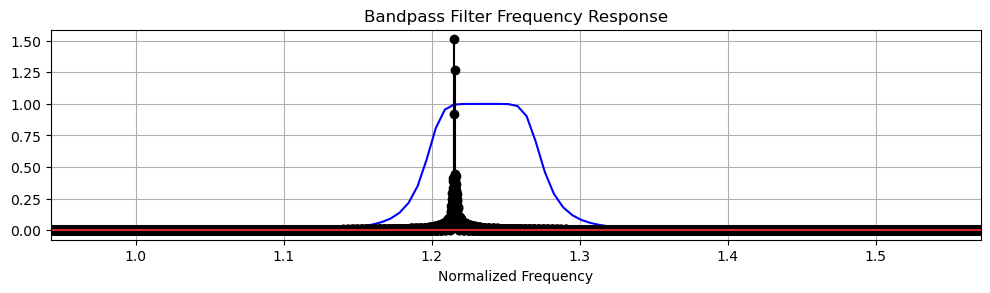

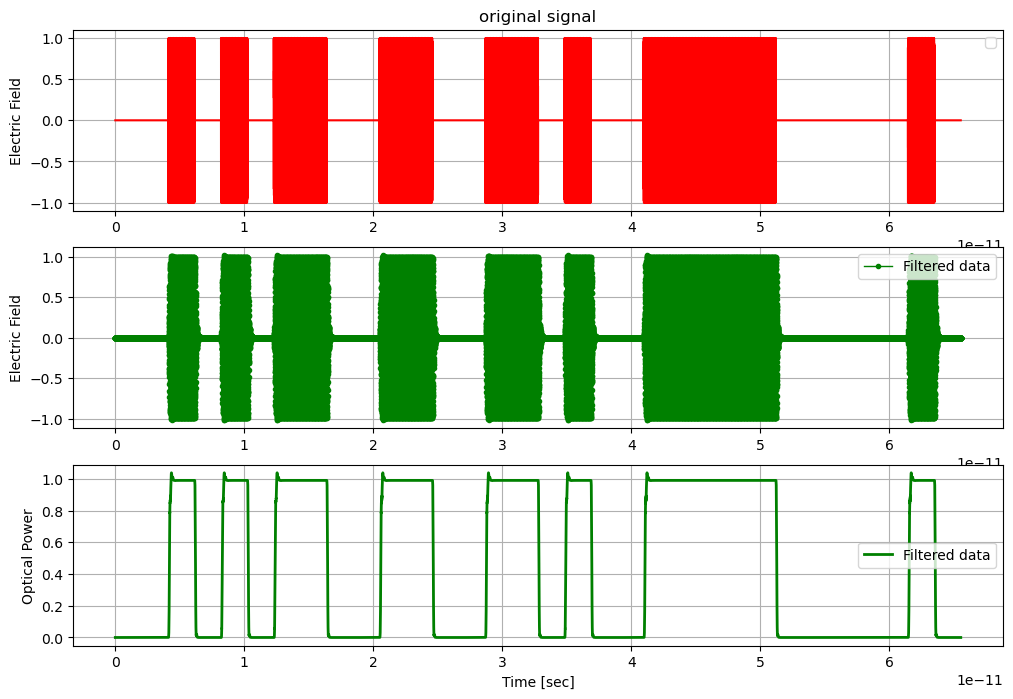

In [3]:
norm_freqcol = np.linspace(-1*np.pi, 1*np.pi, 2*samplerate, endpoint=False)

# Setting standard filter requirements.
order = 4
lowcut = 1.2 / np.pi # [Normalized Frequency. 0 to 1]
highcut = 1.27 / np.pi

b, a = butter(order, [lowcut, highcut], btype='bandpass')

print('b = ', b)
print('a = ', a)

# Plotting the frequency response.
w, h = freqz(b, a) # scipy.signal.freqz: Digital Filter

fig1 = plt.figure(figsize = (12,6), facecolor='white')
ax1_1 = fig1.add_subplot(2, 1, 1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
ax1_1.plot(w, np.abs(h), 'b')

#ax1_1.plot(lowcut, 0.5*np.sqrt(2), 'ko')
#ax1_1.axvline(highcut * np.pi, color='g')
ax1_1.set_title("Bandpass Filter Frequency Response")
ax1_1.set_xlim(0.3*np.pi , 0.5*np.pi)

ax1_1.set_xlabel('Normalized Frequency')
ax1_1.grid()

ax1_1.stem(norm_freqcol, 0.00005*np.abs(Shifted_fft_random_analog_signal),"k",label='Shifted_fft_SelfMixed_carrier_wavecol')

#ax1_2 = fig1.add_subplot(2, 1, 2)
#ax1_2.plot(w, np.angle(h), 'g')

filtered_data1 = lfilter(b, a, Port1_1_EFcol) # scipy.signal.lfilter

fig3 = plt.figure(figsize = (12,8), facecolor='white')
ax3_1 = fig3.add_subplot(3, 1, 1)
ax3_1.plot(tcol,np.real(Port1_1_EFcol),'-', color="r")
ax3_1.set_ylabel("Electric Field")
ax3_1.grid()
ax3_1.legend()
ax3_1.set_title("original signal")

ax3_2 = fig3.add_subplot(3, 1, 2)
ax3_2.plot(tcol, np.real(filtered_data1), 'g.-', linewidth=1, label='Filtered data')
ax3_2.set_ylabel("Electric Field")
ax3_2.grid()
ax3_2.legend()

ax3_3 = fig3.add_subplot(3, 1, 3)
ax3_3.plot(tcol, (np.abs(filtered_data1))**2, 'g-', linewidth=2, label='Filtered data')


ax3_3.set_xlabel('Time [sec]')
ax3_3.set_ylabel("Optical Power")
ax3_3.grid()
ax3_3.legend()
